In [57]:
import numpy as np
import scipy as sp 
import pandas as pd
from scipy.optimize import minimize
import matplotlib
import matplotlib.pyplot as plt
import math as mth
from scipy.optimize import Bounds

In [58]:
# Plotting size
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [59]:
def BlatzKo_eval(x,l=1.0): #Only for confined BCs
    mu = x[0]
    v = x[1]
    phi = x[2]
    #I1 = l**2.
    #I2 = 2.*l**2. + 1.
    #I3 = l**2.
    q = -2.*v/(1.-2.*v)
    J = l**3
    s11 = (mu*phi/J)*(l**2.-J**q) - (mu*(1-phi)/J)*(l**-2-J**-q)
    return s11

def rmse_BlatzKo(x,l_vec=[1],s11_vec=[0]):
    sum = 0.0
    for i in range(l_vec.size):
        s11_pred = BlatzKo_eval(x,l=l_vec[i])
        error = s11_pred-s11_vec[i]
        sum += error**2
    sum = np.sqrt(sum)/np.sqrt(l_vec.size)
    return sum

def BlatzKoR_eval(x,l=1.0):
    mu = x[0]
    s11 = (2.*((mu*(l**2. + 2.))/2. - (l**2.*mu)/2. + (mu*((l**2.)**(3./2.) - (l**2. + 2.)**2./2. + l**4./2. + 1.))/(2.*l**2.)))/(l**2.)**(1./2.)
    return s11

def rmse_BlatzKoR(x,l_vec=[1],s11_vec=[0]):
    sum = 0.0
    for i in range(l_vec.size):
        s11_pred = BlatzKoR_eval(x,l=l_vec[i])
        error = s11_pred-s11_vec[i]
        sum += error**2
    sum = np.sqrt(sum)/np.sqrt(l_vec.size)
    return sum

def NH_eval(x,l=1.0):
    mu = x[0]
    lame = x[1]
    I3 = l**2.
    J = l
    s11 = mu/l*(I3-1.) + lame/J*np.log(J)
    return s11

def rmse_NH(x,l_vec=[1],s11_vec=[0]):
    sum = 0.0
    for i in range(l_vec.size):
        s11_pred = NH_eval(x,l=l_vec[i])
        error = s11_pred-s11_vec[i]
        sum += error**2
    sum = np.sqrt(sum)/np.sqrt(l_vec.size)
    return sum

def OG_eval(x,l=1.0):
    cp = x[0]
    ck = x[1]
    mk = x[2]
    I3 = l**2.
    J = l
    s11 = cp*(J-1.) + (1./J)*(ck/mk)*(l**mk-1.)
    return s11

def rmse_OG(x,l_vec=[1],s11_vec=[0]):
    sum = 0.0
    for i in range(l_vec.size):
        s11_pred = OG_eval(x,l=l_vec[i])
        error = s11_pred-s11_vec[i]
        sum += error**2
    sum = np.sqrt(sum)/np.sqrt(l_vec.size)
    return sum

In [88]:
fit_file = "sig_fit.csv"
fit_data = np.loadtxt(fit_file, delimiter=',', unpack=True)
fit_data = fit_data.transpose()
fit_str = fit_data[:,0] #Stretch
fit_sig = fit_data[:,1] #Stress [MPa]

In [89]:
l_vec = fit_str
s_vec = fit_sig

# Blatz-Ko
x0_BK = np.array([0.000018,0.45,1.]) #[mu,v,phi] initial guesses
bnds = ((0, 100), (0., 0.499),(0.,1.))
res_BK = minimize(rmse_BlatzKo, x0_BK, args=(l_vec,s_vec), bounds=bnds,method='L-BFGS-B')
BK_param = res_BK.x
func_BK = res_BK.fun

# Neo-Hookean
x0_NH = np.array([15.,50.]) #[mu,lame] initial guesses
bnds = ((0., 100), (0., 100))
res_NH = minimize(rmse_NH, x0_NH, args=(l_vec,s_vec), bounds=bnds,method='Powell')
NH_param = res_NH.x
func_NH = res_NH.fun

# Ogden
x0_OG = np.array([15.,50.,1.]) #[cp, ck, mk] initial guesses
bnds = ((1, 100), (0., 100),(0,100))
res_OG = minimize(rmse_OG, x0_OG, args=(l_vec,s_vec), bounds=bnds,method='Powell')
OG_param = res_OG.x
func_OG = res_OG.fun

# Calculate predicted stress
l_plot = np.linspace(l_vec[0],l_vec[-1],100)
s11_pred_BK = BlatzKo_eval(BK_param,l_plot)
s11_pred_NH = NH_eval(NH_param,l_plot)
s11_pred_OG = NH_eval(OG_param,l_plot)

print("Blatz-Ko")
print('Predicted mu = %.8f MPa\n'%(BK_param[0]))
print('Predicted v = %.8f\n'%(BK_param[1]))
print('Predicted phi = %.8f\n'%(BK_param[2]))
print('Function value = %.8f\n'%(func_BK))
print("--------------------------\n")

Blatz-Ko
Predicted mu = 0.00233436 MPa

Predicted v = 0.39803862

Predicted phi = 0.00000000

Function value = 0.00006381

--------------------------



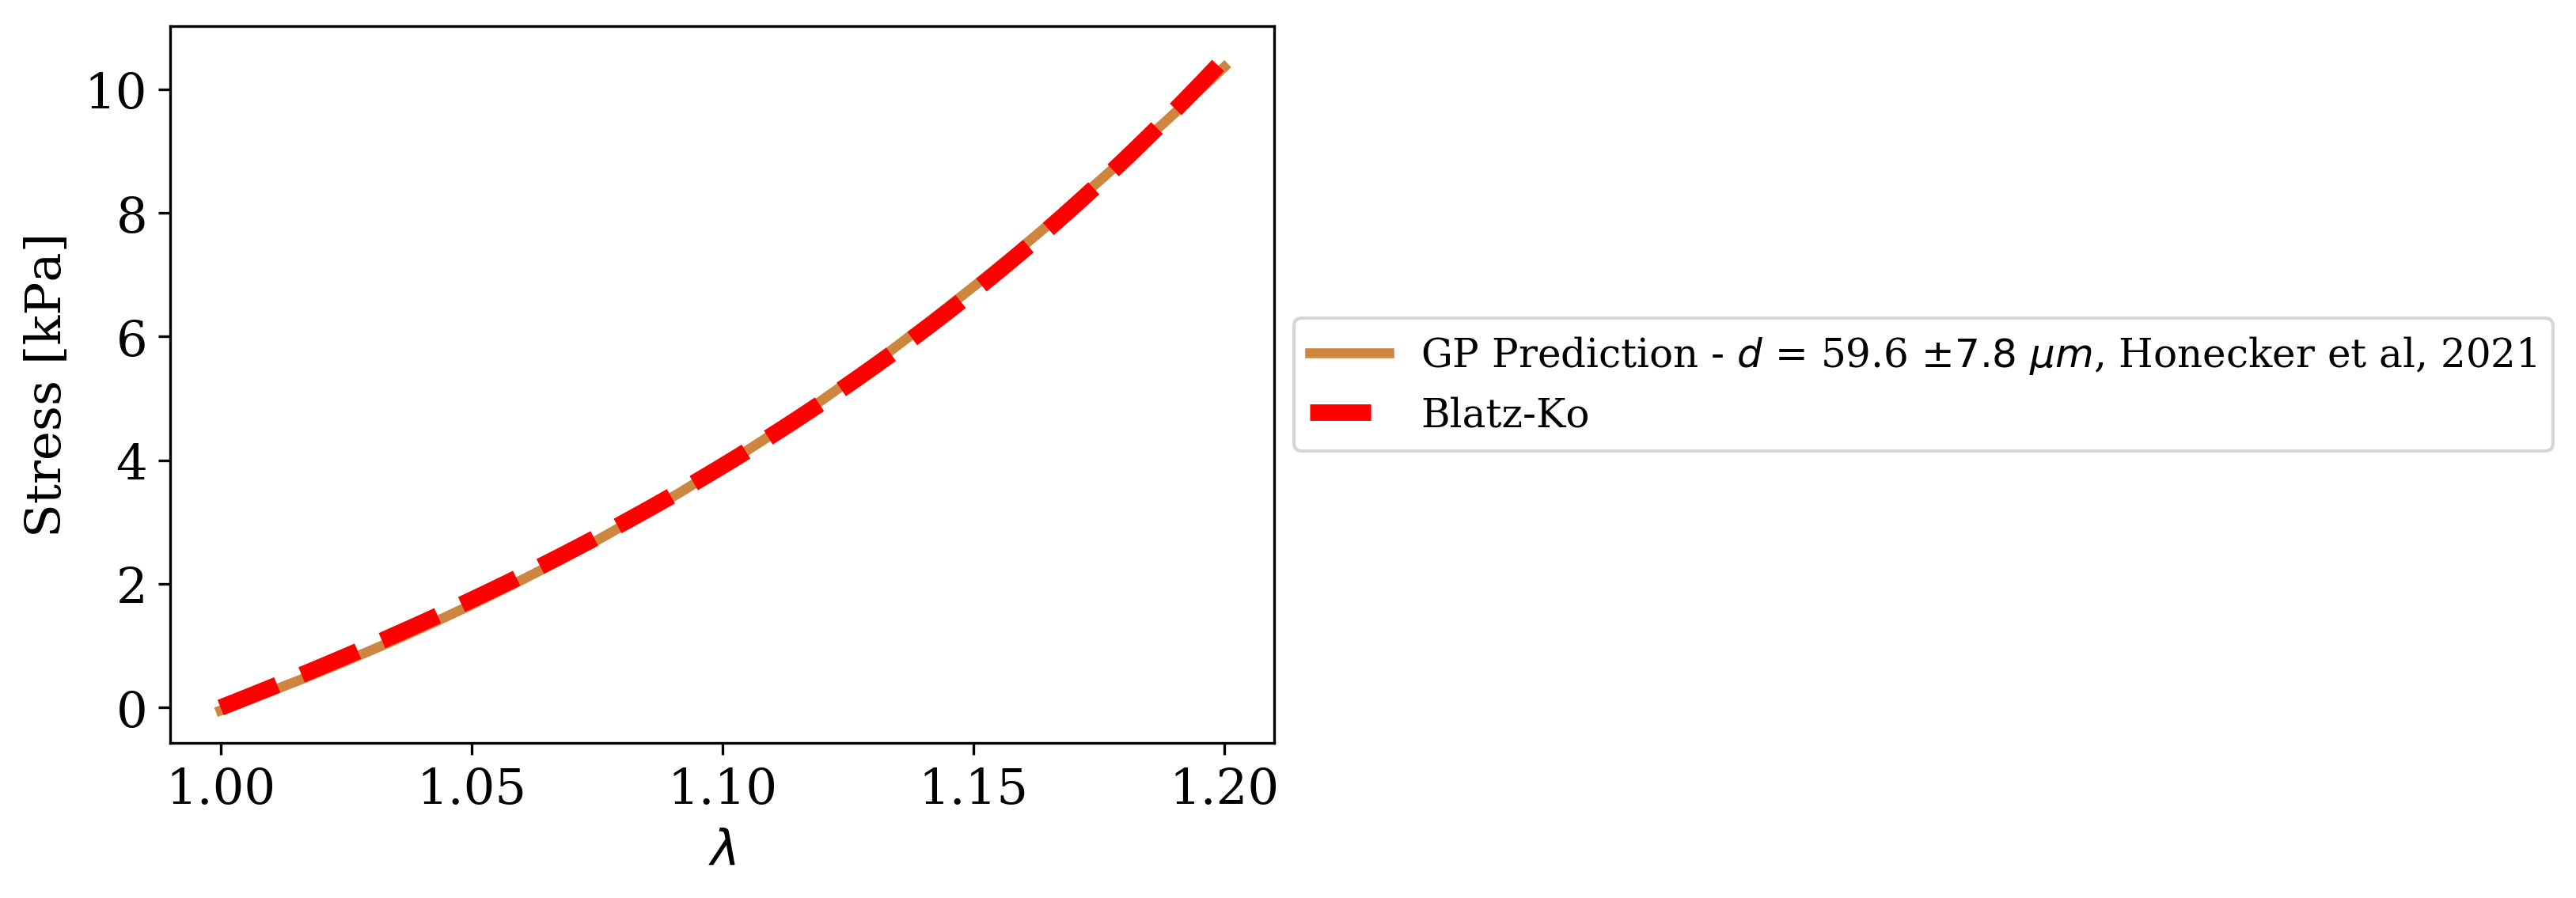

In [91]:
## febio_file = "febio_stress.csv"
febio_data = np.loadtxt(febio_file, delimiter=',', unpack=True)
febio_data = febio_data.transpose()
febio_l = febio_data[:,0] #Stretch
febio_s = febio_data[:,1] #Stress [MPa]

## Plot data
plt.plot(l_vec,s_vec*1000,label="GP Prediction - $d$ = 59.6 $\pm 7.8$ $\mu m$, Honecker et al, 2021",marker='',linestyle="-",color='peru',linewidth=3)
plt.plot(l_plot,s11_pred_BK*1000,label="Blatz-Ko",marker='',linestyle="--",color='red',linewidth=5)
#plt.plot(febio_l,febio_s*1000,label="FeBio",marker='',linestyle="--",color='black',linewidth=3)
#plt.plot(l_plot,s11_pred_NH,label="Pred. NH",marker='',linestyle="-",color='peru')
#plt.plot(1-l_plot,-s11_pred_OG,label="Pred. OG",marker='',linestyle="-",color='green')
#plt.plot(-lf_vec,-sf_vec*10**3,label="Febio-Blatz Ko",marker='x',linestyle="",color='peru')
plt.xlabel('$\lambda$',fontsize=15)
plt.ylabel('Stress [kPa]',fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig('FeBio_BK.png')
# Set the size and DPI of the saved image
fig = plt.gcf()
fig.set_size_inches(6, 4) # 6x4 inches
fig.set_dpi(300) # 300 DPI
# Save the plot as a PNG image
plt.savefig('BK_analytical_RVE.png', bbox_inches='tight')
#plt.savefig('BK_Febio_RVE.png', bbox_inches='tight')
plt.show()